## 首先把下载好的压缩包解压

In [ ]:
!unzip -q weather/weather_round1_train_2007.zip -d weather
#将 weather_round1_train_2007.zip 文件解压缩到 weather 目录中，并且在解压缩过程中不显示详细信息，下方个代码单元同理

In [2]:
!unzip -q weather/weather_round1_train_2008.zip -d weather

In [3]:
!unzip -q weather/weather_round1_train_2009.zip -d weather

In [4]:
!unzip -q weather/weather_round1_train_2010.zip -d weather

In [5]:
!unzip -q weather/weather_round1_train_2011.zip -d weather

In [6]:
!unzip -q weather/weather_round1_test.zip -d weather

## 安装依赖

```shell
pip install importlib-metadata==4.13.0 

pip install zarr lightgbm catboost 

pip install xarray[complete] 
```

In [7]:
#安装名为 importlib-metadata 的包，版本号为 4.13.0
!pip install -q importlib-metadata==4.13.0 

In [8]:
#同时安装三个包，分别是 zarr、lightgbm 和 catboost
!pip install -q zarr lightgbm catboost

In [9]:
#安装 xarray 包，并指定了 [complete] 扩展
!pip install -q xarray[complete]

In [10]:
import numpy as np  # 导入NumPy库，用于数值计算和数组操作
import pandas as pd  # 导入Pandas库，用于数据处理和分析
import xarray as xr  # 导入Xarray库，用于处理标签化的多维数据
from collections import defaultdict, Counter  # 导入defaultdict和Counter类，用于创建默认字典和计数器
import xgboost as xgb  # 导入XGBoost库，用于梯度提升树模型
import lightgbm as lgb  # 导入LightGBM库，也用于梯度提升树模型
from catboost import CatBoostRegressor  # 导入CatBoostRegressor类，用于CatBoost回归模型
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold  # 导入三种交叉验证类，分别是分层K折交叉验证、K折交叉验证和分组K折交叉验证
from sklearn.metrics import mean_squared_error  # 导入均方误差函数
from joblib import Parallel, delayed  # 导入Parallel和delayed类，用于并行化计算任务
from tqdm.auto import tqdm  # 导入tqdm类，用于在循环中显示进度条
import sys, os, gc, argparse, warnings, torch, glob  # 导入其他常用模块，如sys、os、gc、argparse、warnings、torch、glob

warnings.filterwarnings('ignore')  # 设置警告过滤器，将忽略警告信息

# pip install importlib-metadata==4.13.0
# pip install zarr lightgbm catboost
# pip install xarray[complete]

In [11]:
path = './weather'  # 数据集文件路径

def chunk_time(ds):
    # 获取数据集维度的字典并赋值给dims变量
    dims = {k: v for k, v in ds.dims.items()}
    # 在'time'维度上将数据集进行分块处理，每块包含一个时间步
    dims['time'] = 1
    ds = ds.chunk(dims)
    return ds

def load_dataset():
    ds = []  
    for y in range(2007, 2012):  # 遍历年份2007到2011
        data_name = os.path.join(path, f'weather_round1_train_{y}')  # 构建数据文件名
        x = xr.open_zarr(data_name, consolidated=True)  # 打开Zarr格式的数据集文件
        print(f'{data_name}, {x.time.values[0]} ~ {x.time.values[-1]}')  # 输出数据文件名和时间范围
        ds.append(x)  # 将打开的数据集添加到ds列表中
        
    ds = xr.concat(ds, 'time')  # 在'time'维度上连接所有数据集
    ds = chunk_time(ds)  # 对数据集进行时间分块处理
    return ds

ds = load_dataset().x  # 调用load_dataset函数加载数据集，并获取其中的'x'变量


./weather/weather_round1_train_2007, 2007-01-01T00:00:00.000000000 ~ 2007-12-31T18:00:00.000000000
./weather/weather_round1_train_2008, 2008-01-01T00:00:00.000000000 ~ 2008-12-31T18:00:00.000000000
./weather/weather_round1_train_2009, 2009-01-01T00:00:00.000000000 ~ 2009-12-31T18:00:00.000000000
./weather/weather_round1_train_2010, 2010-01-01T00:00:00.000000000 ~ 2010-12-31T18:00:00.000000000
./weather/weather_round1_train_2011, 2011-01-01T00:00:00.000000000 ~ 2011-12-31T18:00:00.000000000


### 构建训练样本

In [12]:
lats = ds.lat.values.tolist()  # 将数据集中的纬度值转换为Python列表，并赋值给lats变量
lons = ds.lon.values.tolist()  # 将数据集中的经度值转换为Python列表，并赋值给lons变量

In [13]:
# 对齐测试数据，每份数据应该是22个时刻
# 获取多份训练数据，滑动5次，每次24个时刻（6天），每次滑动提取最后22个时刻作为一份训练数据
train_data = []
for i in range(5):
    if i == 0:  # 如果是第一份训练数据
        print(-22, 0)  # 输出起始和结束索引
        train_data.append(ds[-22:, :, :, :].values)  # 提取最后22个时刻的数据，添加到训练数据列表中
    else:
        idx = i * 24  # 计算索引偏移量
        train_data.append(ds[-22-idx:-idx, :, :, :].values)  # 提取最后22个时刻的数据，添加到训练数据列表中
        print(-22-idx, -idx)  # 输出起始和结束索引

# 经纬度标识字段
latlon_vals = []
for i in range(161):  # 遍历纬度索引
    for j in range(161):  # 遍历经度索引
        latlon_vals.append([lats[i], lons[j]])  # 将每个纬度和经度对应的值添加到列表中
latlon_vals = np.array(latlon_vals)  # 将列表转换为NumPy数组，并赋值给latlon_vals变量

-22 0
-46 -24
-70 -48
-94 -72
-118 -96


In [14]:
# 确定好20份训练数据后，接下来需要提取特征
for flag, dat in tqdm(enumerate(train_data)):  # 遍历每份训练数据，并显示进度条
    # 第一时刻特征
    first_feat = dat[0,:,:,:].reshape(70,161*161).transpose()  # 将第一时刻的数据转换为特征向量，reshape后的形状为(70, 161*161)，然后进行转置得到(161*161, 70)
    # 第二时刻特征
    second_feat = dat[1,:,:,:].reshape(70,161*161).transpose()  # 将第二时刻的数据转换为特征向量，reshape后的形状为(70, 161*161)，然后进行转置得到(161*161, 70)
    # 两个时刻差分特征
    diff_feat = (dat[1,:,:,:] - dat[0,:,:,:]).reshape(70,161*161).transpose()  # 将两个时刻的数据差分并转换为特征向量，reshape后的形状为(70, 161*161)，然后进行转置得到(161*161, 70)
    
    # 构建训练样本
    tmp_dat = dat[2:,-5:,:,:]  # 从第3个时刻开始获取最后5个时刻的数据，形状为(20, 5, 161, 161)
    for i in range(20):  # 遍历20个时刻
        # 时间特征、经纬特征
        time_vals = np.array([i]*161*161).reshape(161*161,1)  # 创建一个维度为(161*161,1)的数组，每个元素为当前时刻的时间特征i
        sub_vals = np.concatenate((time_vals, latlon_vals), axis=1)  # 将时间特征和经纬度特征拼接在一起，形状为(161*161,3)
        
        # 添加历史特征，第一时刻特征、第二时刻特征、两个时刻差分特征
        sub_vals = np.concatenate((sub_vals, first_feat), axis=1)  # 将第一时刻特征拼接到子特征向量中，形状变为(161*161,73)
        sub_vals = np.concatenate((sub_vals, second_feat), axis=1)  # 将第二时刻特征拼接到子特征向量中，形状变为(161*161,143)
        sub_vals = np.concatenate((sub_vals, diff_feat), axis=1)  # 将两个时刻差分特征拼接到子特征向量中，形状变为(161*161,213)
        
        # 添加5个目标变量，形状变为(161*161,218)
        for j in range(5):
            var_vals = tmp_dat[i,j,:,:].reshape(161*161, 1)  # 将目标变量的数据转换为特征向量，形状为(161*161,1)
            sub_vals = np.concatenate((sub_vals, var_vals), axis=1)  # 将目标变量拼接到子特征向量中
        
        if i == 0 :
            all_vals = sub_vals  # 如果是第一个时刻，则将子特征向量赋值给all_vals
        else:
            all_vals = np.concatenate((all_vals, sub_vals), axis=0)  # 如果不是第一个时刻，则将子特征向量与all_vals进行垂直拼接
        
    if flag == 0:
        final_vals = all_vals  # 如果是第一份训练数据，则将all_vals赋值给final_vals
    else:
        final_vals = np.concatenate((final_vals, all_vals), axis=0)  # 如果不是第一份训练数据，则将all_vals与final_vals进行垂直拼接


0it [00:00, ?it/s]

In [15]:
train_df = pd.DataFrame(final_vals)  # 将提取的特征final_vals转换为DataFrame格式，并赋值给train_df
train_df.columns = ['time','lat','lon'] + [f'feat_{i}' for i in range(210)] + ['t2m','u10','v10','msl','tp']
# 添加列名，分别为时间特征、经度特征、纬度特征、210个特征向量、目标变量t2m、u10、v10、msl和tp

cols = ['time','lat','lon'] + [f'feat_{i}' for i in range(210)]
# 创建列名列表，包括时间特征、经度特征、纬度特征和210个特征向量列名


In [16]:
!mkdir model output
#使用shell命令mkdir来创建两个目录，一个是model目录用于存储模型文件，另一个是output目录用于存储输出文件。!符号表示在代码中执行shell命令。

In [17]:
def train_model(train_x, train_y, label, seed=2023):
    # 初始化交叉验证的变量和参数
    oof = np.zeros(train_x.shape[0])  # 存储交叉验证的预测结果
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)  # 5折交叉验证
    cv_scores = []  # 存储每一折的验证集分数

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} {}************************************'.format(str(i+1), str(seed)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
        #trn_x, trn_y, val_x, val_y：根据索引划分出当前折的训练集和验证集。

        # 设置CatBoost模型的参数
        params = {'learning_rate': 0.5,
                  'depth': 5,
                  'bootstrap_type':'Bernoulli',
                  'random_seed':2023,
                  'od_type': 'Iter',
                  'od_wait': 100,
                  'random_seed': 11,
                  'allow_writing_files': False,
                  'task_type':"GPU",
                  'devices':'0:1'}

        model = CatBoostRegressor(iterations=100, **params)  # 创建CatBoost回归模型
        model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                  cat_features=[],
                  use_best_model=True,
                  verbose=1)  # 在训练集上拟合模型并在验证集上进行评估
        # model.save_model(f'catboost_{label}_fold{i}.model')  # 保存模型
        model.save_model(f'model/catboost_{label}_fold{i}.model')  # 保存模型到指定路径
        val_pred  = model.predict(val_x)  # 在验证集上进行预测
        oof[valid_index] = val_pred  # 将验证集的预测结果填充到oof数组中

        cv_scores.append(np.sqrt(mean_squared_error(val_y, val_pred)))  # 计算并存储验证集的均方根误差
        
        if i == 0: #如果是第一折（i==0），计算特征重要性并保存到CSV文件。
            fea_ = model.feature_importances_
            fea_name = model.feature_names_
            fea_score = pd.DataFrame({'fea_name':fea_name, 'score':fea_})
            fea_score = fea_score.sort_values('score', ascending=False)
            fea_score.to_csv('feature_importances.csv', index=False)

        print(cv_scores) #打印当前折的验证集分数。
    return oof

def inter_model(test_x, label, seed=2023):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)  # 5折交叉验证
    test = np.zeros(test_x.shape[0])  # 存储测试集的预测结果

    params = {'learning_rate': 0.5, 'depth': 6, 'bootstrap_type':'Bernoulli','random_seed':seed, 'metric_period': 300,
              'od_type': 'Iter', 'od_wait': 100, 'random_seed': 11, 'allow_writing_files': False, 'task_type': 'CPU',
              'task_type':"GPU", 'devices':'0:1'}

    for i in range(0, 5):
        # print('************************************ {} {}************************************'.format(str(i+1), str(seed)))
        model = CatBoostRegressor(**params)
        # model.load_model(f'catboost_{label}_fold{i}.model')
        model.load_model(f'model/catboost_{label}_fold{i}.model')  # 加载训练好的模型
        test_pred = model.predict(test_x)  # 在测试集上进行预测
        test += test_pred / kf.n_splits  # 将每一折的预测结果加权平均得到最终的测试集预测结果

    return test



In [18]:
oofs = []  # 存储所有特征的交叉验证预测结果

# 对每个特征进行训练和预测
for label in ['t2m', 'u10', 'v10', 'msl', 'tp']:
    print(f'==================== {label} ====================')
    
    # 调用train_model函数进行训练，并将返回的交叉验证预测结果存储到cat_oof变量中
    cat_oof = train_model(train_df[cols], train_df[label], label)
    
    # 将交叉验证预测结果添加到oofs列表中
    oofs.append(cat_oof)


==================== t2m ====================
************************************ 1 2023************************************
0:	learn: 1.2378006	test: 1.2376878	best: 1.2376878 (0)	total: 14.7ms	remaining: 1.45s
1:	learn: 0.7815934	test: 0.7818239	best: 0.7818239 (1)	total: 29.4ms	remaining: 1.44s
2:	learn: 0.5907490	test: 0.5912015	best: 0.5912015 (2)	total: 43.6ms	remaining: 1.41s
3:	learn: 0.5198964	test: 0.5205360	best: 0.5205360 (3)	total: 58.6ms	remaining: 1.41s
4:	learn: 0.4870645	test: 0.4877316	best: 0.4877316 (4)	total: 71.8ms	remaining: 1.36s
5:	learn: 0.4692424	test: 0.4698925	best: 0.4698925 (5)	total: 86.4ms	remaining: 1.35s
6:	learn: 0.4583620	test: 0.4590182	best: 0.4590182 (6)	total: 100ms	remaining: 1.33s
7:	learn: 0.4470283	test: 0.4475557	best: 0.4475557 (7)	total: 114ms	remaining: 1.31s
8:	learn: 0.4339699	test: 0.4344714	best: 0.4344714 (8)	total: 128ms	remaining: 1.29s
9:	learn: 0.4281233	test: 0.4287467	best: 0.4287467 (9)	total: 142ms	remaining: 1.27s
10:	lear

In [19]:
train_df.head() #查看数据集前五行

,time,lat,lon,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_205,feat_206,feat_207,feat_208,feat_209,t2m,u10,v10,msl,tp
0,0.0,50.0,100.00,-4.514620,-4.506903,-4.288303,-3.989979,-3.628431,-3.401888,-3.131553,...,-0.674277,-0.088560,-0.023765,0.073370,0.0,-6.211315,0.609452,-0.306112,2.303155,-0.604822
1,0.0,50.0,100.25,-4.530884,-4.521255,-4.301620,-4.008497,-3.653694,-3.426081,-3.152735,...,-0.418350,-0.110939,0.041425,0.056571,0.0,-5.608399,0.484209,-0.188961,2.248176,-0.604822
2,0.0,50.0,100.50,-4.547148,-4.533813,-4.316594,-4.028692,-3.680758,-3.450274,-3.173910,...,-0.384310,-0.087370,0.075655,0.069316,0.0,-5.605404,0.486061,0.080605,2.248359,-0.604822
3,0.0,50.0,100.75,-4.563421,-4.546361,-4.328246,-4.045526,-3.704220,-3.472449,-3.192436,...,-0.443774,-0.053089,0.012427,0.028576,0.0,-5.914448,0.978930,0.091716,2.149359,-0.604822
4,0.0,50.0,101.00,-4.577876,-4.558918,-4.338231,-4.062355,-3.729483,-3.496637,-3.213619,...,-0.446717,-0.028330,0.005887,-0.021424,0.0,-6.066376,1.016897,0.335195,2.054393,-0.604822


### 预测结果

In [20]:
def get_test_data(dat):
    # 第一时刻特征
    first_feat = dat[0,:,:,:].reshape(70,161*161).transpose() # 将第一时刻的特征数据从(70, 161, 161)转换为(161*161, 70)

    # 第二时刻特征
    second_feat = dat[1,:,:,:].reshape(70,161*161).transpose() # 将第二时刻的特征数据从(70, 161, 161)转换为(161*161, 70)

    # 两个时刻差分特征
    diff_feat = (dat[1,:,:,:] - dat[0,:,:,:]).reshape(70,161*161).transpose() # 计算两个时刻特征之间的差分，并将结果从(70, 161, 161)转换为(161*161, 70)
    
    # 构建测试样本
    for i in range(20): # 20个时刻
        # 时间特征、经纬特征
        time_vals = np.array([i]*161*161).reshape(161*161,1) # 创建一个形状为(161*161, 1)的数组，每个元素都是i
        sub_vals = np.concatenate((time_vals, latlon_vals), axis=1) # 将时间特征和经纬度特征按列进行拼接，形状为(161*161, 3)
        
        # 添加历史特征，第一时刻特征、第二时刻特征、两个时刻差分特征
        sub_vals = np.concatenate((sub_vals, first_feat), axis=1) # 将第一时刻特征拼接到sub_vals中，形状为(161*161, 73)
        sub_vals = np.concatenate((sub_vals, second_feat), axis=1) # 将第二时刻特征拼接到sub_vals中，形状为(161*161, 143)
        sub_vals = np.concatenate((sub_vals, diff_feat), axis=1) # 将两个时刻差分特征拼接到sub_vals中，形状为(161*161, 213)
        
        if i == 0 :
            all_vals = sub_vals
        else:
            all_vals = np.concatenate((all_vals, sub_vals), axis=0) # 将sub_vals沿着行方向进行拼接
            
    df = pd.DataFrame(all_vals) # 将结果转换为DataFrame格式
    df.columns = ['time','lat','lon'] + [f'feat_{i}' for i in range(210)] # 给DataFrame的列命名
    return df


In [21]:
def get_parallel_result(file):
    # 加载输入数据
    input_data = torch.load(file)  # 加载保存在文件中的输入数据

    # 生成测试样本，并构建特征
    test_df = get_test_data(np.array(input_data))  # 根据输入数据生成测试样本并构建特征

    # 保存结果
    res = test_df[['time']]  # 创建一个只包含时间列的DataFrame用于保存结果

    # 模型推理，预测测试集结果
    for label in ['t2m', 'u10', 'v10', 'msl', 'tp']:
        # 通过模型推理预测测试集结果，inter_model是一个未给出的模型推理函数
        cat_pred = inter_model(test_df[cols], label)
        res[label] = cat_pred  # 将预测结果保存到res中

    # 转为提交格式
    for label in ['t2m', 'u10', 'v10', 'msl', 'tp']:
        for i in range(20):
            sub_vals = res[res['time'] == i][label].values.reshape(1, 161, 161)
            # 将时间为i的某个标签的预测结果转换为形状为(1, 161, 161)的数组

            if i == 0:
                all_vals = sub_vals
            else:
                all_vals = np.concatenate((all_vals, sub_vals), axis=0)
                # 将所有时间步的预测结果按时间序列连接起来，形状为(20, 161, 161)

        all_vals = all_vals.reshape(20, 1, 161, 161)

        if label == 't2m':
            final_vals = all_vals
        else:
            final_vals = np.concatenate((final_vals, all_vals), axis=1)
            # 将不同标签的预测结果按照通道连接起来，形状为(20, 5, 161, 161)

    final_vals = torch.tensor(final_vals)  # 将最终的结果转换为PyTorch张量
    save_file = file.split('/')[-1]  # 获取保存结果的文件名

    # torch.save(final_vals.half(), f'./{save_file}')  # 将结果以半精度浮点类型保存到指定路径中
    torch.save(final_vals.half(), f'output/{save_file}')  # 将结果以半精度浮点类型保存到指定路径中


In [22]:
# 并行处理指定目录下的文件
Parallel(n_jobs=8)( #创建一个并行处理的上下文，指定使用 8 个工作线程。

    # 对每个文件路径调用 get_parallel_result 函数进行处理
    delayed(get_parallel_result)(file_path)
    #使用 delayed 函数将 get_parallel_result 函数及其参数 file_path 封装起来，表示要对每个文件路径调用 get_parallel_result(file_path) 进行处理
    
    # 遍历指定目录下以 .pt 为后缀的文件路径
    for file_path in tqdm(glob.glob(f'{path}/weather_round1_test/input/*.pt'))
    #使用glob.glob函数获取指定目录下所有以 .pt 结尾的文件路径，并使用 tqdm 函数在进度条中显示遍历的进度。
)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_578/2963632858.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_578/2963632858.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_578/2963632858.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_578/296363285

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# 输出结果

In [23]:
#将output文件夹压缩，如果这段代码无法生成output.zip，运行下面的代码
_ = !zip -r output.zip output/

In [26]:
import zipfile, os
path = './output/'  # 要压缩的文件路径
zipName = 'output.zip'  # 压缩后的zip文件路径及名称

# 创建一个新的zip文件
f = zipfile.ZipFile(zipName, 'w', zipfile.ZIP_DEFLATED)
#使用zipfile模块创建一个新的zip文件对象，指定为写模式('w')并采用ZIP_DEFLATED压缩算法。

# 遍历指定路径下的所有文件和文件夹
for dirpath, dirnames, filenames in os.walk(path): #使用os.walk函数遍历指定路径下的所有文件和文件夹，包括子文件夹
    for filename in filenames: #遍历每个文件夹中的文件名。
        print(filename)
        # 将文件添加到zip文件中
        f.write(os.path.join(dirpath, filename))

# 关闭zip文件
f.close()


# 获得成绩
## 下载结果文件
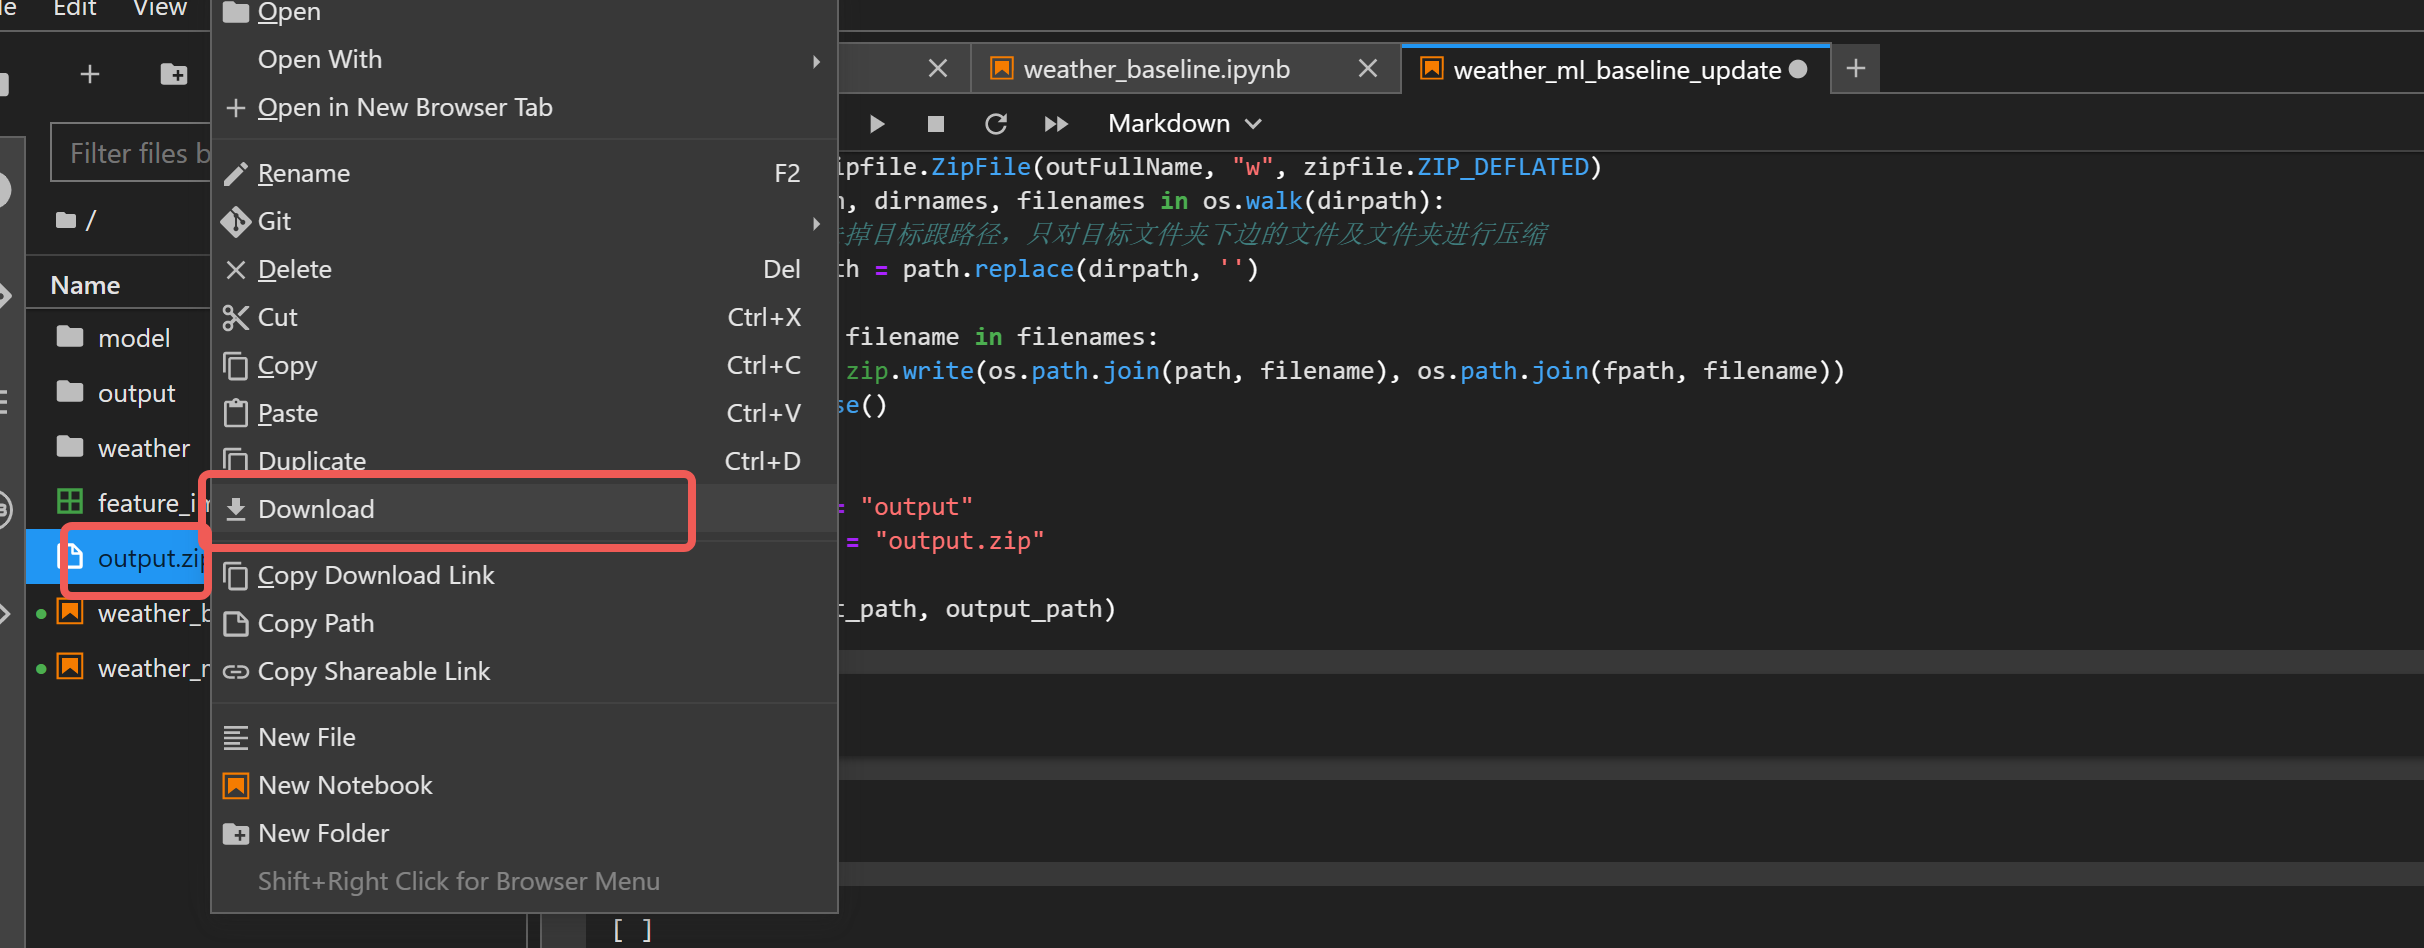

如果下载输出压缩包快完成报网络错误：参考文档中的方法来解决：https://xqbbve5hpvs.feishu.cn/docx/DiooduxPHoCbv4xk5atc9Td5npe#BbDFdMvJboqFntxfI3TcxkZDnOe

## 提交结果
点击【提交结果】，上传刚下载的output.zip文件
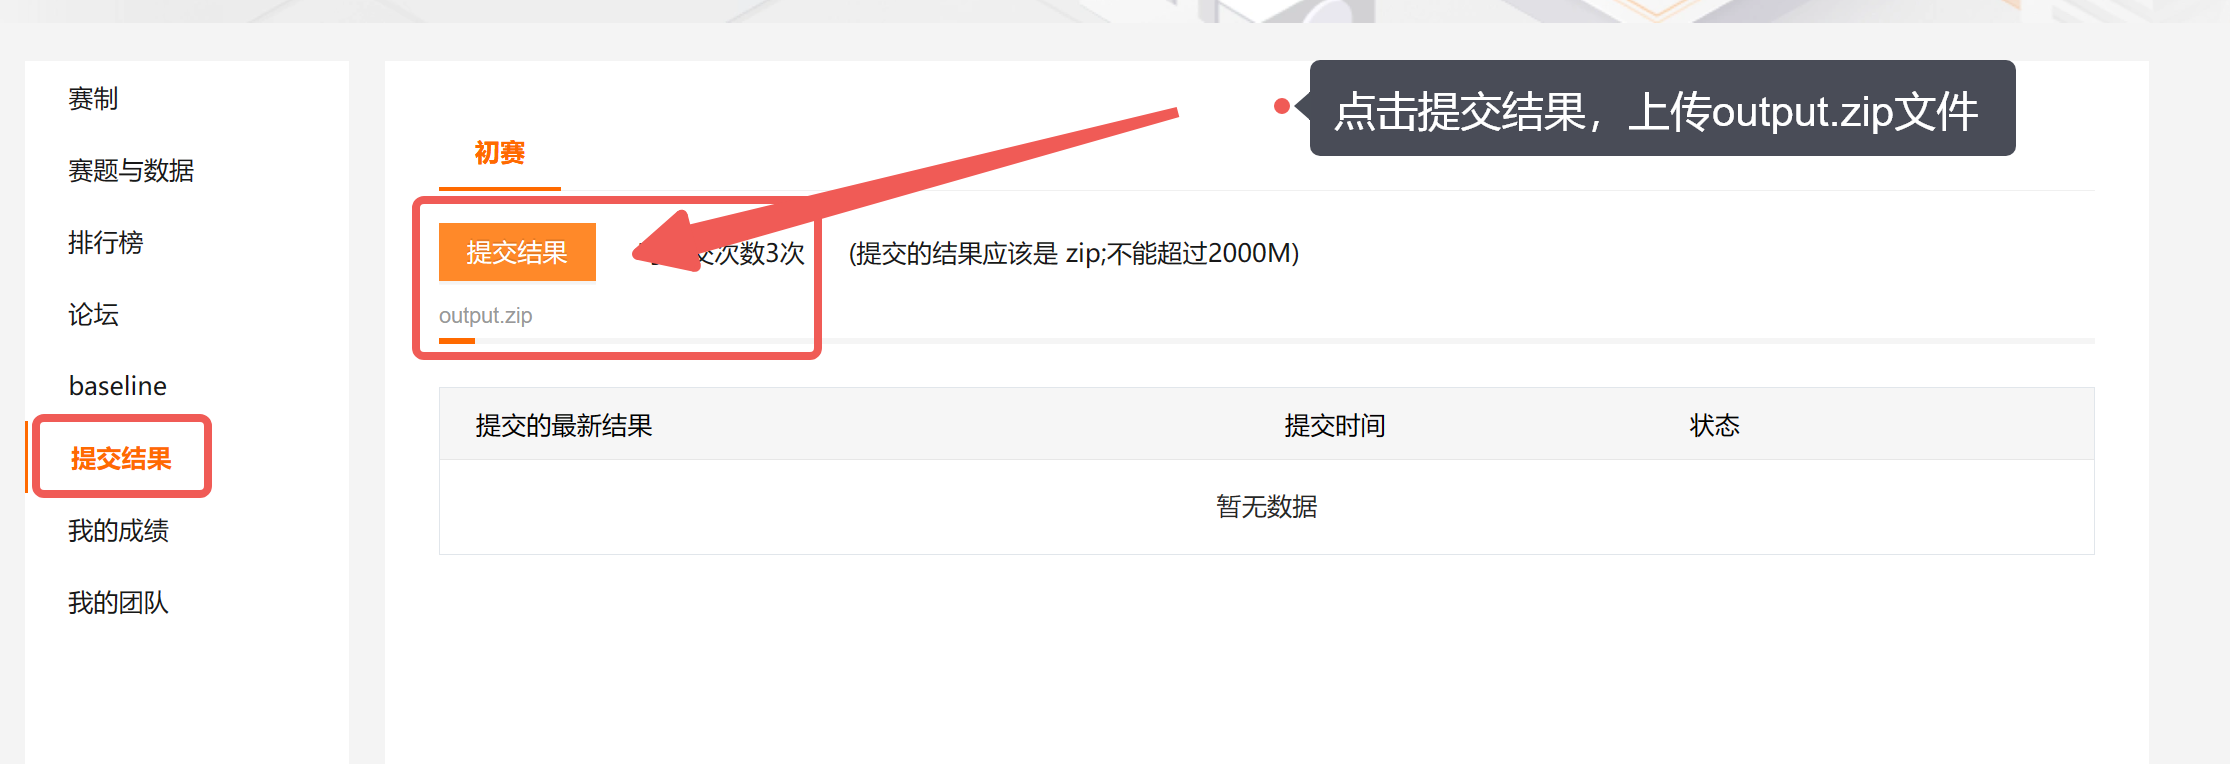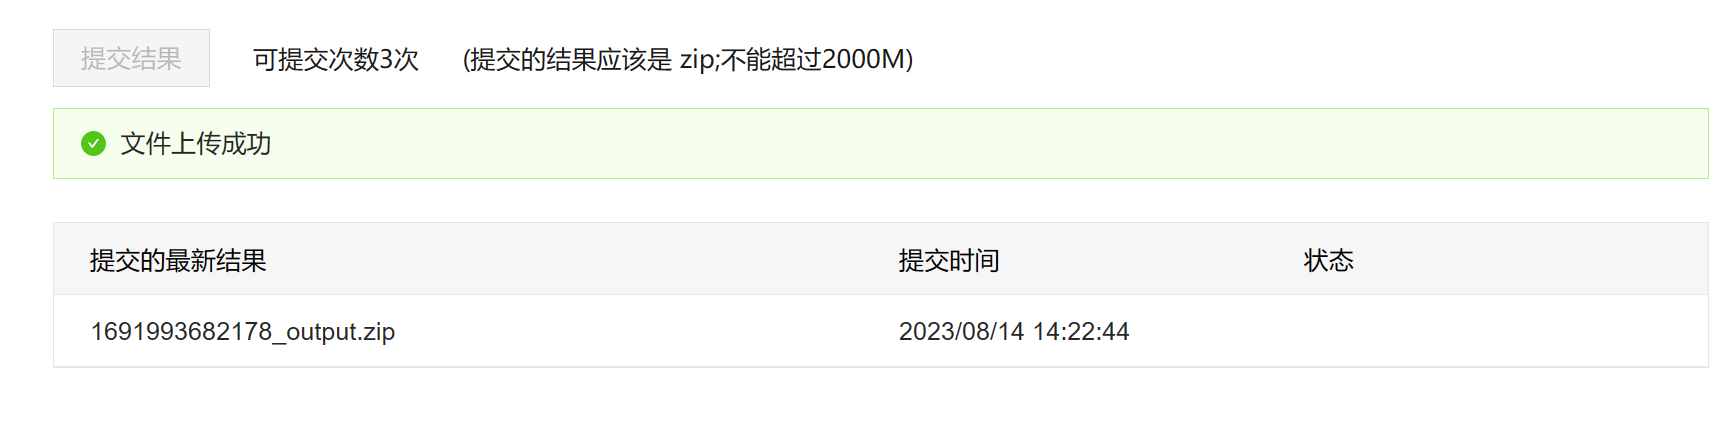
